# Example of End-to-End Reinforcement Learning From Human Feedback (RLHF) Workflow
### Example of Using SFTTrainer, RewardModelTrainer, and PPOTrainer to perform RLHF training

**Authors**:
- Fachriza Dian Adhiatma (fachriza.d.adhiatma@gdplabs.id)

**Reviewers**:
- Muhammad Afif Al Hawari (muhammad.a.a.hawari@gdplabs.id)

## References
[1] [GLAIR GenAI Internal SDK - SFTTrainer](https://github.com/GDP-ADMIN/gen-ai-internal/blob/main/gdplabs_gen_ai/model_training/sft_trainer.py) \
[2] [GLAIR GenAI Internal SDK - RewardModelTrainer](https://github.com/GDP-ADMIN/gen-ai-internal/blob/main/gdplabs_gen_ai/model_training/rm_trainer.py) \
[3] [GLAIR GenAI Internal SDK - PPOTrainer](https://github.com/GDP-ADMIN/gen-ai-internal/blob/main/gdplabs_gen_ai/model_training/ppo_trainer.py) \
[4] [GLAIR GenAI Internal SDK - TransformersLLM](https://github.com/GDP-ADMIN/glair-genai-experiments-and-explorations/blob/main/glair_genai_sdk/llm/transformers_llm.py) \
[5] [PEFT: Parameter-Efficient Fine-Tuning of Billion-Scale Models on Low-Resource Hardware](https://huggingface.co/blog/peft)

## Flow Diagram

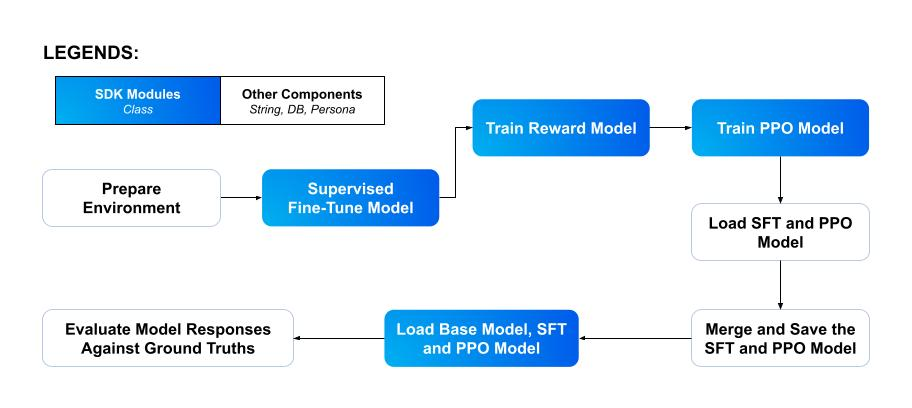

The flow diagram illustrates the process of fine-tuning a Large Language Model (LLM) using Reinforcement Learning From Human Feedback (RLHF), which includes the following steps:

1. **Prepare Environment**: Download the necessary data and install the required libraries to begin fine-tuning.
2. **Supervised Fine-Tune Model**: Begin supervised fine-tuning the Large Language Model (LLM) with specific data and configurations.
3. **Train Reward Model**: Train the Large Language Model (LLM) for calculating score given a text input, with specific data and configurations.
4. **Train PPO Model**: Train the Large Language Model (LLM) for generating a response which is more aligned with human preferences given a prompt.
5. **Load SFT and PPO Model**: Since we are doing fine-tuning with LoRA, and the output only provides model adapters (not the entire fine-tuned model), we need to load these adapters alongside the pretrained model.
6. **Merge and Save the SFT and PPO Model**: We then combine the SFT adapter with its pretrained and also  the PPO adapter with its pretrained model in order to use the SFT and PPO model.
7. **Load Base Model, SFT Model, and PPO Model**: Load the original base (pretrained) model, the SFT model, and the PPO model to generate output using predefined questions.
8. **Evaluate Model Responses Against Ground Truths**: Assess the model's performance and accuracy by testing its output against a set of known correct answers.

To run the example, you can point to **Run in Colab** or **View Source on GitHub** to see the source repo.

## Prepare Environment
In this example, we will try to fine-tune the [Llama-2-7b-chat](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf) model with the [Reddit Summarization TL;DR](https://drive.google.com/drive/folders/1bMf36fOU972G180rL7IF92vcWFgXLTQj?usp=drive_link) dataset. Before fine-tuning, please make sure to install the SDK library and download the Truthful QA dataset to your local file system.

To install the SDK library, you need to create a personal access token on GitHub. Please follow these steps:
1. You need to log in to your [GitHub Account](https://github.com/).
2. Go to the [Personal Access Tokens](https://github.com/settings/tokens) page.
3. If you haven't created a Personal Access Tokens yet, you can generate one.
4. When generating a new token, make sure that you have checked the `repo` option to grant access to private repositories.
5. Now, you can copy the new token that you have generated and paste it into the script below.

In [ ]:
import getpass
import subprocess
import sys
import os

def install_sdk_library():
    token = getpass.getpass("Input Your Personal Access Token: ")

    cmd = f"pip install \"gdplabs_gen_ai @ git+https://{token}@github.com/GDP-ADMIN/gen-ai-internal.git\""

    with subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True) as process:
        stdout, stderr = process.communicate()

        if process.returncode != 0:
            sys.stdout.write(stderr)
            raise subprocess.CalledProcessError(returncode=process.returncode, cmd=cmd)
        else:
            sys.stdout.write(stdout)

install_sdk_library()

<b>Warning:</b>
After running the command above, you need to restart the runtime in Google Colab for the changes to take effect. Not doing so might lead to the newly installed libraries not being recognized.

To restart the runtime in Google Colab:
- Click on the `Runtime` menu.
- Select `Restart runtime`.

<b>Note: We highly recommend that you run the following code on a GPU instead of a CPU for optimal performance.</b>

Simply go to `Runtime` > `Change runtime type` in the menu, select the desired GPU as the `Hardware accelerator`, and hit `Save`. This ensures faster execution of the code. To fine-tune a Large Language Model (LLM) with 7 billion parameters or more without quantization, you will need a minimum of 40 GB of GPU memory, or an equivalent to A100 instances in Google Colab.

In [ ]:
MODEL_NAME = "meta-llama/Llama-2-7b-chat-hf"
DATASET_PATH = "./reddit_summarize_tldr.csv"
RM_DATASET_PATH = "./reddit_summarize_comparisons.csv"
PPO_DATASET_PATH = "./reddit_summarize_tldr_prompt_only.csv"
SAVED_MODEL_NAME_PREFIX = "Llama-2-7b-chat-hf"

## Supervised Fine-Tuning (SFT) the Model
Once you have completed the previous step, you are ready to execute the following code:

In [ ]:
from gdplabs_gen_ai.model_training.sft_trainer import SFTTrainer

sft_trainer = SFTTrainer(
    pretrained_model_name_or_path=MODEL_NAME,
    dataset_path=DATASET_PATH
)
sft_trainer.train()

After the supervised fine-tuning (SFT) is complete, the results will be saved in a folder with the default name `output`.

For a rough estimate, a dataset with 5000 rows, where each entry has a length of 2048 tokens, running on a single instance of A6000 - 48 GB GPU, will take approximately 20-24 hours. The running time when using either an A6000 or A100 instance is expected to be approximately the same.

## Train the Reward Model
After you trained a SFT model, the next step is to train the reward model. The data needed to train a reward model are prompt, chosen answer, and rejected answer. The `RewardModelTrainer` expects that prompts are stored in `prompt` column, chosen answers are stored in `chosen` column, and rejected answers are stored in `rejected` column.

There are two ways to initiate the reward model, training the reward model from scratch (initiating it from a base model) or starting with the SFT model. Which one is the best?
- Researchers from OpenAI in [Training Language Models To Follow Instructions With Human Feedback](https://arxiv.org/abs/2203.02155) and [Learning To Summarize From](https://arxiv.org/abs/2009.01325) use the SFT model to initiate a reward model.
- Chip Huyen's Blog titled [RLHF: Reinforcement Learning from Human Feedback](https://huyenchip.com/2023/05/02/rlhf.html) suggests to initiate a reward model with the SFT model.
- Weight and Biases's Blog titled [Implementing RLHF: Learning to Summarize with trlX](https://wandb.ai/carperai/summarize_RLHF/reports/Implementing-RLHF-Learning-to-Summarize-with-trlX--VmlldzozMzAwODM2) uses the SFT model to initiate a reward model.

If you want to train a reward model from scratch or starting from a base model, you can follow the code below.

In [ ]:
from gdplabs_gen_ai.model_training.rm_trainer import RewardModelTrainer

rm_trainer = RewardModelTrainer(
    pretrained_model_name_or_path=MODEL_NAME,
    dataset_path=RM_DATASET_PATH
  )
rm_trainer.train()

But, if you want to start with the SFT model instead, you must replace the `peft_adapter_or_path` argument with the directory where you saved the SFT PEFT adapter, which is in this case `output/final`.

In [ ]:
from gdplabs_gen_ai.model_training.rm_trainer import RewardModelTrainer

rm_trainer = RewardModelTrainer(
    pretrained_model_name_or_path=MODEL_NAME,
    peft_adapter_or_path="output/final",
    dataset_path=RM_DATASET_PATH
  )
rm_trainer.train()

After reward model training is complete, the result will be saved in a folder `output/final-rm`.

## Train The PPO Model
Now we have the SFT model and the reward model. We will use these two models to perform reinforcement learning using PPO algorithm. The SFT model will be used to initiate the PPO model, and the reward model will be used to calculate reward during training. The data needed to train a PPO model using `PPOTrainer` is prompt only which should be stored in a column named `prompt`.

In [ ]:
from gdplabs_gen_ai.model_training.ppo_trainer import PPOTrainer

ppo_trainer = PPOTrainer(
    pretrained_model_name_or_path=MODEL_NAME,  # The base model for PPO training.
    peft_adapter_path="./output/final",  # Directory where you saved the SFT adapter.
    rm_model_name_or_path=MODEL_NAME,  # The base model for reward model training.
    rm_peft_adapter_path="./output/final-rm",  # Directory where you saved the trained reward model.
    dataset_path=PPO_DATASET_PATH
)
ppo_trainer.train()

After PPO training is complete, the result will be saved in a folder `output/final-ppo`.

## Inference and Evaluation
To perform model inference using the SDK, we can use the [TransformersLLM](https://github.com/GDP-ADMIN/gen-ai-internal/blob/main/gdplabs_gen_ai/llm/transformers_llm.py) class. Please note that this class is based on the Hugging Face Transformers, meaning that it only accepts the model saved in Hugging Face model format. Meanwhile, the SFT model and the PPO model you just trained are just PEFT adapters, so you should merge the adapter with its base model first, and then save it as full model. To do that, please follow the steps below.

### Load Your SFT Model
After the `output` folder is created, you will see several folders inside it, namely, checkpoint-xxx and final, where
`xxx` refers to the number of training steps at which the checkpoint was saved.

You can use the checkpoint or final folder to load your fine-tuned model and use it for inference.
You can use the following code to load the fine-tuned model adapters and append them to the pretrained model.

In [ ]:
from peft import PeftModel
from transformers import AutoModelForCausalLM

pretrained_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
peft_adapters_path = "./output/final"
sft_model = PeftModel.from_pretrained(pretrained_model, peft_adapters_path)

### Merge and Save the SFT Model
After we have the `sft_model`, we need to merge it using the `merge_and_unload()` method. This allows us to load it in the same way we would load a pretrained model with [TransformersLLM](https://github.com/GDP-ADMIN/gen-ai-internal/blob/main/gdplabs_gen_ai/llm/transformers_llm.py). Remember to save the tokenizer as well, since both the model and tokenizer are essential for future use. We will save both the model and tokenizer in the `./Llama-2-7b-chat-hf-fine-tuned` folder.

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
sft_model = sft_model.merge_and_unload()
sft_model.save_pretrained(f"./{SAVED_MODEL_NAME_PREFIX}-fine-tuned")
tokenizer.save_pretrained(f"./{SAVED_MODEL_NAME_PREFIX}-fine-tuned")

### Load, Merge and Save the PPO Model
In the `output` folder, there is a folder named `final-ppo` where the trained PPO model is saved. You can use this folder to load the trained PPO model. Please note that since the SFT model is used to initiate the PPO model, then you should load the SFT model first and then add the PPO adapter on top of that.

In [ ]:
sft_model = AutoModelForCausalLM.from_pretrained(f"./{SAVED_MODEL_NAME_PREFIX}-fine-tuned")
peft_adapters_path = "./output/final-ppo"
ppo_model = PeftModel.from_pretrained(sft_model, peft_adapters_path)

After we have the `ppo_model`, we can merge its PEFT adapter with the base model using `merge_and_unload()`. Then we can save the merged model and its tokenizer.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
ppo_model = ppo_model.merge_and_unload()
ppo_model.save_pretrained(f"./{SAVED_MODEL_NAME_PREFIX}-ppo")
tokenizer.save_pretrained(f"./{SAVED_MODEL_NAME_PREFIX}-ppo")

### Load Base Model, SFT Model, and PPO Model using the `TransformersLLM`
Before you proceed with this step, ensure that you have merged your SFT model adapters with the original
pretrained model and merged the PPO model with the SFT model. Please refer to the steps on how to `Merge and Save the SFT Model` for more information.

Define the paths to your base model, SFT model, and PPO model. Note that loading both models will require substantial GPU
resources, so consider loading them one at a time. In this section, we assume that the base model is loaded using the HuggingFace repo ID, and the SFT model and PPO model are loaded from the local file system located at `./Llama-2-7b-chat-hf-fine-tuned` and `./Llama-2-7b-chat-hf-ppo`.

In [ ]:
from gdplabs_gen_ai.llm.transformers_llm import TransformersLLM

BASE_MODEL = MODEL_NAME
SFT_MODEL = f"./{SAVED_MODEL_NAME_PREFIX}-fine-tuned"
PPO_MODEL = f"./{SAVED_MODEL_NAME_PREFIX}-ppo"

base_llm = TransformersLLM(BASE_MODEL, torch_dtype="auto")
sft_llm = TransformersLLM(SFT_MODEL, torch_dtype="auto")
ppo_llm = TransformersLLM(PPO_MODEL, torch_dtype="auto")

Here, we also define `generation_config` to control the behavior of the model's responses, and specify the prompt that will be used for both the base model and the fine-tuned model.

In [ ]:
generation_config = dict(
    max_new_tokens=64,
    num_beams=1,
    repetition_penalty=1.17,
    top_k=49,
    top_p=0.14,
    typical_p=1,
)  # You can override the generation configuration here or leave it empty to use the default values.

prompts = [
    "SUBREDDIT: r/AskReddit TITLE: How do you get someone out of your head? POST: Hi, I'm 22, and I have been with my girlfriend for 5 years now. We recently moved together. We've always loved each other intensely. Problem, I recently started to have feelings for an other person (a friend). This person has had a boyfriend for now 3 years, and has absolutely no ideas. Those feelings were so strong, it was hard to hide them. After 2 months of me being distant and really sad, my girlfriend forced me to say what was bothering me. I'm not a good liar, and now she knows. We decided to give us a week alone, I went to my parents. Now, I'm completely lost. I keep on thinking about this person, and I hate that. I would like for those feelings to go away, to leave me alone. But I can't. What do I do? It's been 3 months now, and I'm just desperate. TL;DR:",
    "SUBREDDIT: r/pettyrevenge TITLE: So, my mom woke me up with a loud TV. POST: She was in her living room, watching TV. This was at about 8:30 in the morning, and she was exercising. She turned the TV up extra loud to hear it over her excercycle, and woke me up. I went in there asking for her to turn it down. She said she didn't have to; I explained that I always used headphones so she didn't have to deal with my noise and that she should give me a little more respect, given that I paid rent at the time. She disagreed. I went back to my room, rather pissed off at the lack of equality. I had no lock on my door; but I had a dresser right next to it, so I pulled one of the drawers out enough so that it caused the door to not be openable. Then, I turned my speakers up really loud and blasted Gangnam Style on repeat, with the bass cranked up as high as it could go. If you hate Gangnam Style for being overplayed, you will see why I chose that particular song. I personally don't mind it. But here's the thing about my bass; it vibrates the walls, making one hell of a lot of noise. Needless to say, my mom was not pleased and shut off the internet. But it was oh so worth it. TL;DR:"
]

After that, we can generate responses for both the base, the SFT model, and PPO model.

In [ ]:
answers_from_base_model = []
for prompt in prompts:
    base_answer = base_llm(prompt, **generation_config)
    answers_from_base_model.append(base_answer.replace(prompt, "").strip())

print(answers_from_base_model)
# ["I have feelings for someone else, but they're in a committed relationship, and I'm struggling to get them out of my head. AMA.",
# 'I got revenge on my mom by blasting loud music and vibrating the walls with my bass, after she woke me up with her loud TV in the morning.']

In [ ]:
answers_from_sft_model = []
for prompt in prompts:
    sft_answer = sft_llm(prompt, **generation_config)
    answers_from_sft_model.append(sft_answer.replace(prompt, "").strip())

print(answers_from_sft_model)
# ["I have feelings for someone else, I'm in a relationship, I'm lost, I want those feelings to go away.",
# 'Mom woke me up with loud TV, I got pissed, and I got revenge by blasting Gangnam Style on repeat with my bass.']

In [ ]:
answers_from_ppo_model = []
for prompt in prompts:
    ppo_answer = ppo_llm(prompt, **generation_config)
    answers_from_ppo_model.append(ppo_answer.replace(prompt, "").strip())

print(answers_from_ppo_model)
# ["I'm in love with a friend, I'm 22, and I don't know what to do.",
#  'Mom woke me up with loud TV, I got pissed off, and I made her pay for it.']

### Evaluate Model Responses Against Ground Truths
In this section, we will show you how to automatically evaluate your model's answers against the ground truths using BERT.
You need to install the required dependency by running the following code:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
! pip install bert-score

<b>Note:</b> The automatic evaluation using BERT requires downloading the model before performing the calculations.

In [ ]:
# Below are the ground truths for each prompt.
ground_truths = ["long relationship; fell in love with an other person; admitted it; would like it to disappear, though it doesn't.",
                 "Mom had the TV on loud and woke me up, didn't care that I'd respected audio levels in the house, so I countered with playing Gangnam Style on repeat with the bass thumping through the walls."]

Use the code below to evaluate the comparison between ground truths and predictions.

In [ ]:
import numpy as np
from bert_score import score

def evaluate(ground_truths, predictions):
    refs = [str(answer) for answer in ground_truths]
    cands = [str(pred) for pred in predictions]

    # Calculate the score, and download the model if it has not been downloaded yet.
    precision, recall, f1 = score(cands, refs, lang="other", verbose=True)

    # Convert tensors to numpy arrays.
    precision_np = precision.numpy()
    recall_np = recall.numpy()
    f1_np = f1.numpy()

    # Calculate the mean of the scores.
    mean_precision = np.mean(precision_np)
    mean_recall = np.mean(recall_np)
    mean_f1 = np.mean(f1_np)

    print("----Evaluation Results----")
    print("Precision: {:.2f}%".format(mean_precision * 100))
    print("Recall: {:.2f}%".format(mean_recall * 100))
    print("F1 Score: {:.2f}%".format(mean_f1 * 100))

After that, run the `evaluate` function for the base model, SFT model, and PPO model.

In [ ]:
evaluate(ground_truths, answers_from_base_model)

In [ ]:
evaluate(ground_truths, answers_from_sft_model)

In [ ]:
evaluate(ground_truths, answers_from_ppo_model)